# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False,
                 vis_loss=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.vis_loss = vis_loss

    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1 / (1 + np.exp(-(X @ weights)))
    
    def get_loss(self, X, weights, y):
        """Calculate the loss."""
        return np.log(1 + np.exp((-(X @ weights)) * y)).sum()\
                / y.shape[0] + np.linalg.norm(weights) / (2 * self.C)       
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]

        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        losses = []
        for i in range(self.max_iter):
            delta = -(y.reshape(-1, 1) * X_ext * (1 - 1 / (1 + (np.exp(-( X_ext @ self.weights_) * y))))\
                      .reshape(-1, 1)).sum(axis=0) / y.shape[0] + self.weights_ / self.C
            self.weights_ -= self.eta * delta
            
            loss = self.get_loss(X_ext, self.weights_, y)
            losses.append(loss)

            if np.linalg.norm(self.eta * delta) < self.tol:
                break
      
        if self.vis_loss:
            plt.plot(range(i+1), losses, label=f'Learning rate {self.eta}, C {self.C}')
            plt.legend()
            plt.ylabel('Loss')
            plt.xlabel('Iter')
#             plt.show()
            
        return self
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            probs = self.get_sigmoid(X_ext, self.weights_)
#             return np.array(list(zip(1-probs,probs)))
            return probs
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        pred = self.predict_proba(X)
        return np.where(pred < 0.5, -1, 1)

In [5]:
from sklearn import datasets
from sklearn import metrics

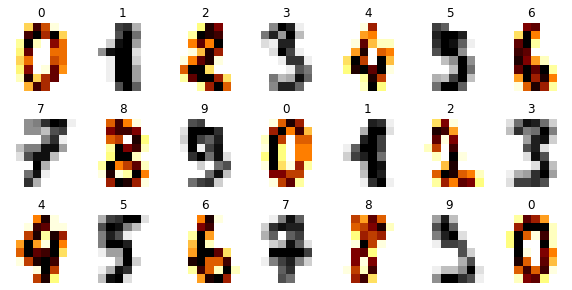

In [6]:
%matplotlib inline
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)    
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")    
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.get_loss(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1]),np.array([0.58662, 0.40131]))

1.0432592001139394

In [12]:
lr_clf.fit(X_train, y_train)

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model = CustomLogisticRegression()

j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


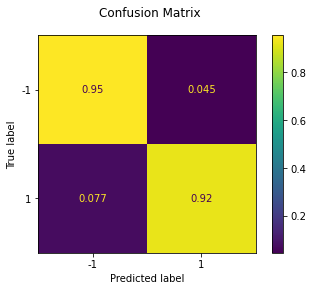

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

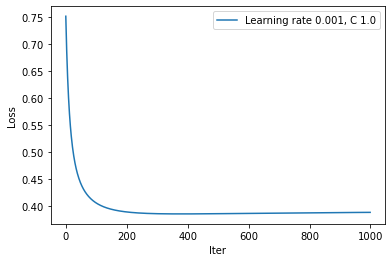

In [18]:
CustomLogisticRegression(vis_loss=True).fit(X_train, y_train)

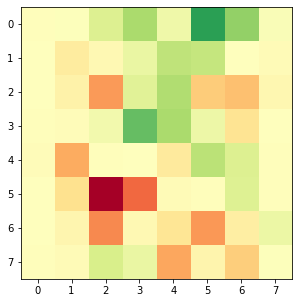

In [19]:
## your code
coef = model.fit(X_train, y_train).weights_[1:]
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
plt.imshow(coef.reshape(8, 8), interpolation='nearest',
           cmap=plt.cm.RdYlGn, vmin=-scale, vmax=scale)

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

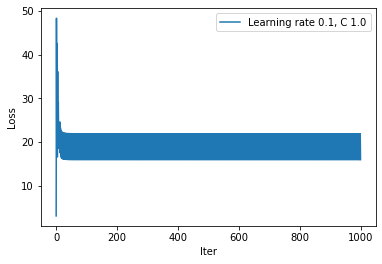

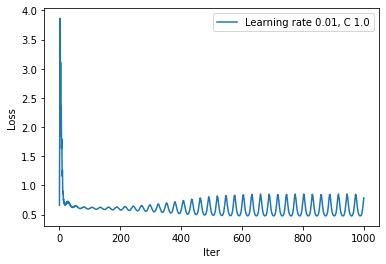

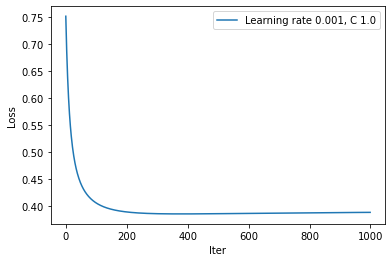

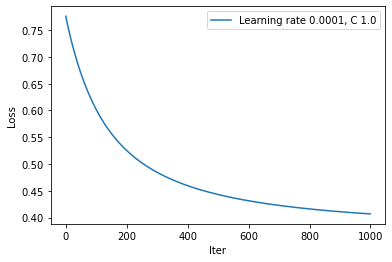

In [20]:
## your code
for i in [0.1,0.01,0.001, 0.0001]:
    CustomLogisticRegression(eta=i, vis_loss=True).fit(X_train, y_train)
    plt.show()

< your thoughts >
При значениях learning rate [0.1,0.01] алгоритм не может определить минимум Logistic Regression loss - не сходится. При 0.001 минимальное значение ошибки достигается примерно за 300 итераций, далее - улучшений нет (в этом случае, возможно уменьшение уровня tol для оптимизации). При learning rate 0.0001 и 1000 итераций минимум не достигается, так как существенно сокращена скорость поиска - необходимо увеличение max_iter.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

Text(0.5, 1.0, 'Loss for the different C regularization parameter values')

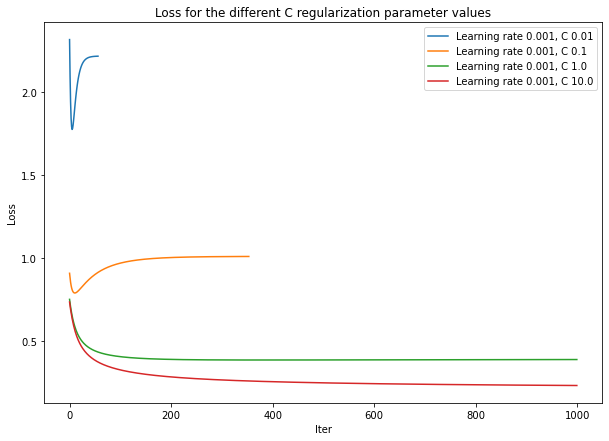

In [21]:
## your code
plt.subplots(figsize=[10,7])
train_accs = []
test_accs = []
C = [0.01, 0.1, 1.0, 10.0]
for c in C:
    clf = CustomLogisticRegression(C=c, vis_loss=True).fit(X_train, y_train)
    train_acc = round(metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), 2)
    test_acc = round(metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test), 2)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
plt.title('Loss for the different C regularization parameter values')

C = 0.01 , train_acc: 0.85 , test_acc: 0.88
C = 0.1 , train_acc: 0.89 , test_acc: 0.91
C = 1.0 , train_acc: 0.91 , test_acc: 0.94
C = 10.0 , train_acc: 0.92 , test_acc: 0.94


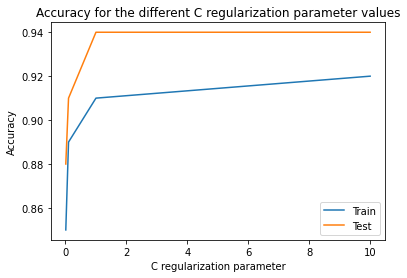

In [22]:
for i in range(len(C)):
    print('C =', C[i], ', train_acc:', train_accs[i], ', test_acc:', test_accs[i])
plt.title('Accuracy for the different C regularization parameter values')
plt.plot(C, train_accs, label='Train')
plt.plot(C, test_accs, label='Test')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('C regularization parameter')
plt.show()

< your thoughts >
С увеличением С-параметра регулязации увеличилось качество модели

**(0.5 points)** Compare zero initialization and random initialization. 

j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


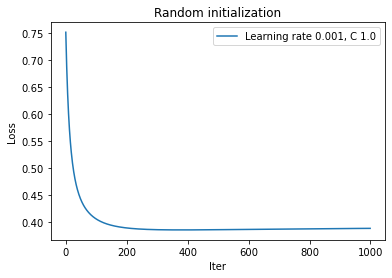

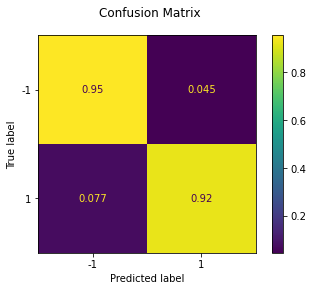

j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


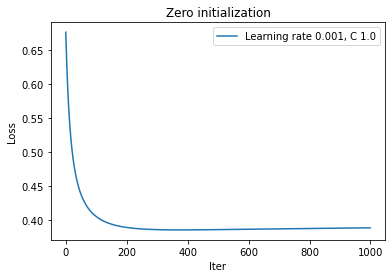

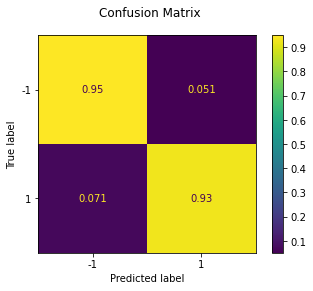

random initialization -  train_acc: 0.9109255393180237 test_acc: 0.9388888888888889
zero initialization -  train_acc: 0.9116214335421016 test_acc: 0.9388888888888889


In [23]:
## your code
mod = CustomLogisticRegression(vis_loss=True)
plt.title('Random initialization')
train_acc, test_acc = fit_evaluate(mod, X_train, y_train, X_test, y_test)
mod_z = CustomLogisticRegression(vis_loss=True, zero_init=True)
plt.title('Zero initialization')
train_acc_z, test_acc_z = fit_evaluate(mod_z, X_train, y_train, X_test, y_test)
print('random initialization - ', 'train_acc:', train_acc,  'test_acc:', test_acc)
print('zero initialization - ', 'train_acc:', train_acc_z, 'test_acc:', test_acc_z)

< your thoughts >
Инициализация весов нолями против случайных равномерно распределенных чисел, значительно не повлияло на качество моделей

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [24]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9, method_distance='euclidian'):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
                
            method_distance : 'euclidian', 'manhattan', 'minkowski'
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        self.method_distance = method_distance
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            p: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        n_samples = X.shape[0]
        k_samples = Y.shape[0]
        p = np.zeros((n_samples, k_samples))
        
        degree = 2
        if self.method_distance == 'manhattan':
            degree = 1
        elif self.method_distance == 'minkowski':
            degree = 3
            
        for i in range(n_samples):
            for j in range(k_samples):
#                     p[i,j] = np.linalg.norm(X[i] - Y[j])
                p[i,j] = np.sum(np.abs(X[i] - Y[j])**degree)**(1/degree)
                    
        return p
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samples,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        dc = {}
        for i in range(y.size):
            dc[y[i]] = dc.get(y[i], 0) + weights[i]
        return np.array([dc[x] for x in self.classes_])
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        return self
    
    def kneighbors(self, X):
        p = self.get_pairwise_distances(self.points, X)
        k = self.n_neighbors
        idx_sort = np.argsort(p, axis=0)[:k,:].T
        idx_neighbors = []
        p_neighbors = []
        
        for i in range(idx_sort.shape[0]):
            idx = [[x, i] for x in idx_sort[i]]
            idx_neighbors += idx
            p_neighbors += [p[i[0]][i[1]] for i in idx]
            
        return np.array(p_neighbors), idx_neighbors        
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
            
        if hasattr(self, 'points'):
            p_neighbors, idx_neighbors = self.kneighbors(X)
            classes_ = list(self.classes_)
            y = self.y
            sum_weights_of_points = np.zeros((X.shape[0], len(classes_)))
            weights_of_points = np.ones(p_neighbors.shape)
        
            if self.weights == 'distance':
                weights_of_points = 1 / (p_neighbors + self.eps)
            for i in range(p_neighbors.shape[0]):
                sum_weights_of_points[idx_neighbors[i][1]][classes_.index(y[idx_neighbors[i][0]])]\
                    +=  weights_of_points[i]

            probs = sum_weights_of_points/sum_weights_of_points.sum(axis=1).reshape(-1,1)
            return probs

        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")    
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        probs = self.predict_proba(X)
        return self.classes_[probs.argmax(axis = 1)]

In [25]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [26]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [27]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

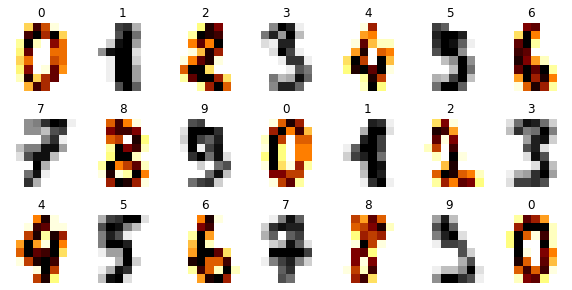

In [28]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [29]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [30]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


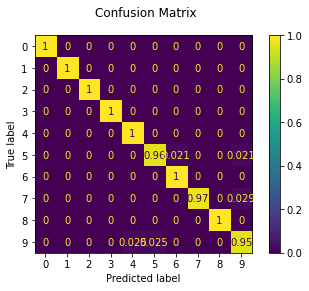

In [31]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [32]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts > Из confusion matrix видно, что модель "путает" цифру 9 с цифрами 4, 5 и 7, а так же цифры 5 и 6. Что объясняется схожестью в написании данных цифр

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

N_neighbors: 1


j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


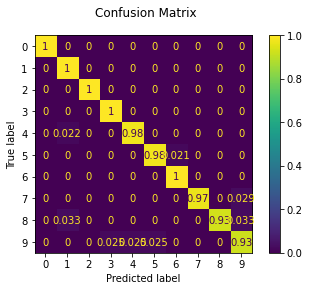

N_neighbors: 3


j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


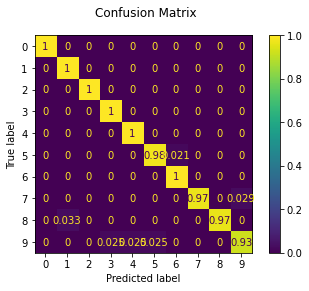

N_neighbors: 5


j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


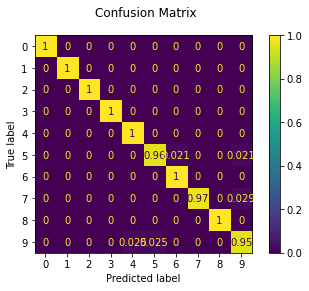

N_neighbors: 7


j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


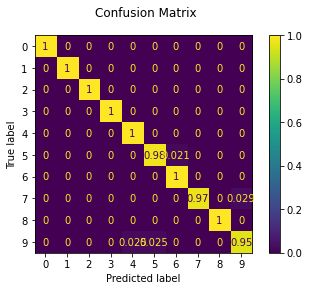

N_neighbors: 10


j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


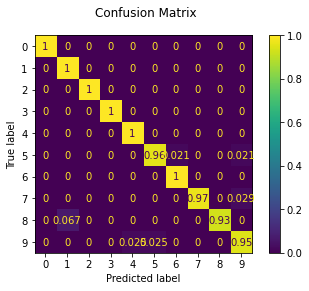

In [33]:
## your code
train_accs = []
test_accs = []
N_neighbors = [1, 3, 5, 7, 10]
for n in N_neighbors:
    print(f'N_neighbors: {n}')
    model = CustomKNeighborsClassifier(n_neighbors=n, weights='distance')
    model.fit(X_train, y_train)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    train_accs.append(round(train_acc, 3))
    test_accs.append(round(test_acc, 3))

n_neighbors = 1 , train_acc: 1.0 , test_acc: 0.978
n_neighbors = 3 , train_acc: 1.0 , test_acc: 0.983
n_neighbors = 5 , train_acc: 1.0 , test_acc: 0.986
n_neighbors = 7 , train_acc: 1.0 , test_acc: 0.989
n_neighbors = 10 , train_acc: 1.0 , test_acc: 0.981


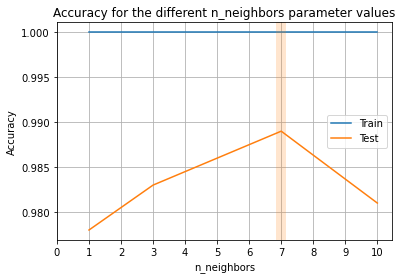

In [34]:
for i in range(len(N_neighbors)):
    print('n_neighbors =', N_neighbors[i], ', train_acc:', train_accs[i], ', test_acc:', test_accs[i])
    
plt.title('Accuracy for the different n_neighbors parameter values')
plt.plot(N_neighbors, train_accs, label='Train')
plt.plot(N_neighbors, test_accs, label='Test')
plt.axvline(N_neighbors[np.argmin(abs(np.array(train_accs)-np.array(test_accs)))], color='C1', lw=10, alpha=0.2)
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('n_neighbors')
plt.grid(True)
plt.xticks(range(11))
plt.show()

< your thoughts > При небольшом параметре n_neighbors <5 модель недообучается, при n_neighbors более 7 происходит снижение качества модели (переобучение), из-за включения в модель большего количества "соседей", характеристики, которых схожи, но соответствуют уже другим категориям

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

Weights uniform


j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


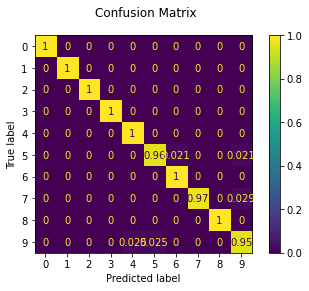

weights:  uniform , train_acc:  0.99 , test_acc:  0.99
Weights distance


j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


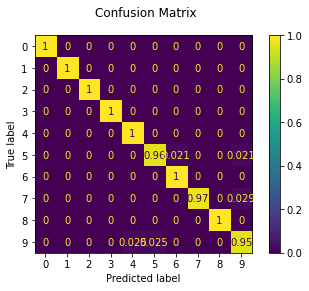

weights:  distance , train_acc:  1.0 , test_acc:  0.99


In [35]:
## your code
for w in ['uniform', 'distance']:
    print('Weights', w)
    model = CustomKNeighborsClassifier(weights=w)
    model.fit(X_train, y_train)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    print('weights: ', w, ', train_acc: ', round(train_acc, 2), ', test_acc: ', round(test_acc, 2))

< your thoughts > В данном случае качество тестовой модели не зависит от метода расчета вероятности, но на тренировочной выборке метод расчета distance показал результат 1 против 0,99 - uniform. Можно сделать вывод, что метод отбора признаков distance является более точным, но не на много.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

measurement_distance:  euclidian


j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


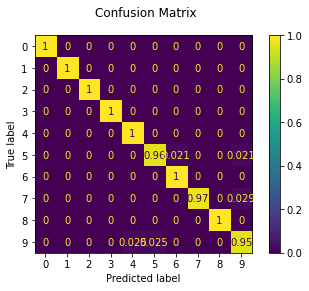

method_distance:  euclidian , train_acc:  0.99 , test_acc:  0.99
measurement_distance:  manhattan


j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


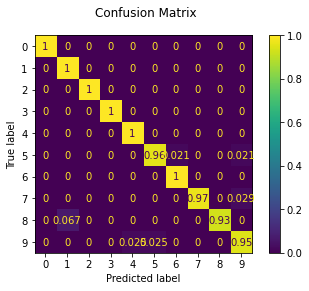

method_distance:  manhattan , train_acc:  0.99 , test_acc:  0.98
measurement_distance:  minkowski


j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


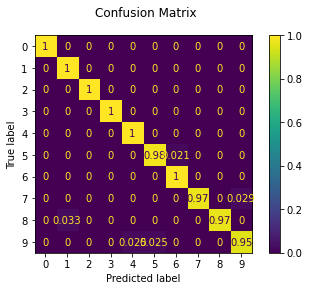

method_distance:  minkowski , train_acc:  0.99 , test_acc:  0.99


In [36]:
train_accs = []
test_accs = []
D = ['euclidian', 'manhattan', 'minkowski']
for d in D:
    print('measurement_distance: ', d)
    model = CustomKNeighborsClassifier(method_distance=d)
    model.fit(X_train, y_train)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    train_accs.append(round(train_acc, 3))
    test_accs.append(round(test_acc, 3))
    print('method_distance: ', d, ', train_acc: ', round(train_acc, 2), ', test_acc: ', round(test_acc, 2))

distance measurement function = euclidian , train_acc: 0.99 , test_acc: 0.986
distance measurement function = manhattan , train_acc: 0.99 , test_acc: 0.981
distance measurement function = minkowski , train_acc: 0.991 , test_acc: 0.986


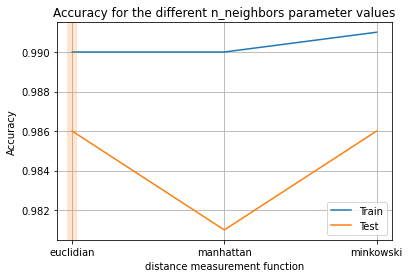

In [37]:
for i in range(len(D)):
    print('distance measurement function =', D[i], ', train_acc:', train_accs[i], ', test_acc:', test_accs[i])
    
plt.title('Accuracy for the different n_neighbors parameter values')
plt.plot(D, train_accs, label='Train')
plt.plot(D, test_accs, label='Test')
plt.axvline(D[np.argmin(abs(np.array(train_accs)-np.array(test_accs)))], color='C1', lw=10, alpha=0.2)
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('distance measurement function')
plt.grid(True)
plt.show()

< your thoughts > В данной ситуации лучшие результаты euclidian и minkowski (3-тья степень).

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts > Для данного задания лучшими являются параметры:
n_neighbors = 7, weights = 'distance', method_distance = 'euclidian'.
Можно было предложить использовать cross_validation, но, вообщем, качество модели является высоким и без дополнительных функций

j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


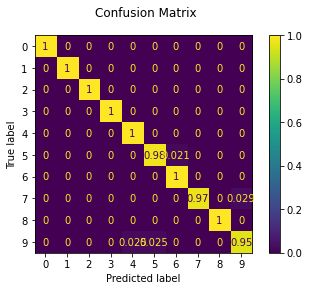

train_acc:  1.0 , test_acc:  0.99


In [38]:
model = CustomKNeighborsClassifier(n_neighbors = 7, weights = 'distance', method_distance = 'euclidian')
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('train_acc: ', round(train_acc, 2), ', test_acc: ', round(test_acc, 2))

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [39]:
PATH = "./data/"

In [40]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [41]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [42]:
## your code
data['Sex'].value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

In [43]:
data['Survived'].value_counts()

0    57226
1    42774
Name: Survived, dtype: int64

In [44]:
data.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0           12660
        1           31226
male    0           44566
        1           11548
Name: Survived, dtype: int64

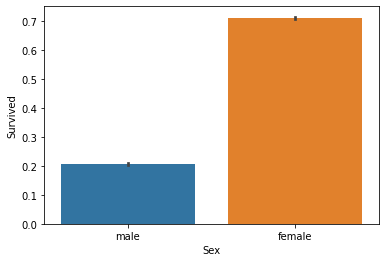

In [45]:
sns.barplot(x='Sex', y='Survived', data=data)

< your thoughts > Среди выживших больше женщин, так как мужчины пожервовали своей жизнью ради их спасения

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [46]:
data['Age'].describe()

count    96708.000000
mean        38.355472
std         18.313556
min          0.080000
25%         25.000000
50%         39.000000
75%         53.000000
max         87.000000
Name: Age, dtype: float64

In [47]:
print(f"The average age of survived {round(data['Age'][data['Survived']==1].mean(), 1)}\
        and deceased {round(data['Age'][data['Survived']==0].mean(),1)} passengers")


The average age of survived 40.6        and deceased 36.7 passengers


In [48]:
print(f"The median age of survived {data['Age'][data['Survived']==1].median()}\
        and deceased {data['Age'][data['Survived']==0].median()} passengers")

The median age of survived 43.0        and deceased 36.0 passengers


In [49]:
data['Age'][data['Survived']==1].describe()

count    41418.000000
mean        40.553799
std         18.742172
min          0.080000
25%         27.000000
50%         43.000000
75%         55.000000
max         87.000000
Name: Age, dtype: float64

In [50]:
data['Age'][data['Survived']==0].describe()

count    55290.000000
mean        36.708695
std         17.809058
min          0.080000
25%         24.000000
50%         36.000000
75%         52.000000
max         83.000000
Name: Age, dtype: float64

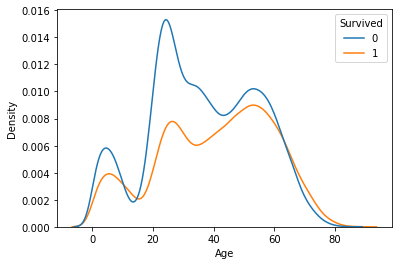

In [51]:
sns.kdeplot(data=data, x='Age', hue='Survived')

In [52]:
female_age = pd.cut(data['Age'][data['Sex']=='female'].dropna(), bins=range(0, 120, 20)).value_counts()
female_age

(40, 60]     15340
(20, 40]     12662
(0, 20]       7368
(60, 80]      7089
(80, 100]       42
Name: Age, dtype: int64

In [53]:
male_age = pd.cut(data['Age'][data['Sex']=='male'].dropna(), bins=range(0, 120, 20)).value_counts()
male_age

(20, 40]     23539
(40, 60]     18499
(0, 20]       7629
(60, 80]      4534
(80, 100]        6
Name: Age, dtype: int64

< your thoughts > Выживших меньше между 20 и 40 годами, так как в этом возрасте на корабле было гораздо больше мужчин, что видно по раcпределению по бинам

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

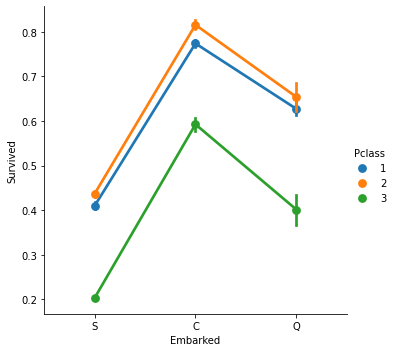

In [54]:
## your code
# sns.scatterplot(x=data['Pclass'], y=data['Embarked'], hue=data['Survived'])
sns.catplot(x="Embarked", y="Survived", hue="Pclass", kind="point", data=data)

In [55]:
data['Embarked'].value_counts()

S    72139
C    22187
Q     5424
Name: Embarked, dtype: int64

In [56]:
data['Pclass'].value_counts()

3    41006
1    30315
2    28679
Name: Pclass, dtype: int64

< your thoughts > Заметно, что выживших из 1 и 2 классов больше, а так же наибольшая доля выживших из порта С.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [57]:
## your code
data.isna().mean() * 100

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 11.2+ MB


In [59]:
data.duplicated().value_counts()

False    100000
dtype: int64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages? 

< your thoughts > Отсутствующие значения Age и Fare можно заменить медианными, Cabin попробовать преобразовать: отсутствующие в 1, остальные в 0 (возможно, отсутствие/наличие признака оказывает влияние), Embarked заменить на S - порт с большим количеством пассажиров.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [60]:
def ticket_split(s):
    s = sorted(str(s).split())
    z = ''
    if s and len(s) > 1:
        z = sum(map(int, list(s[0])))
    else:
        z = 0
    return z

def dummies_categories(data):
    data1 = data.copy()
    data1['Sex'] = (data1['Sex'] == 'male').astype('int')
    data1['Cabin'] = (data1['Cabin'].isna()).astype('int')
    data1['Age'].fillna(data['Age'].median(), inplace=True)
    data1['Fare'].fillna(data['Fare'].median(), inplace=True)
    data1['Embarked'].fillna('S', inplace=True)
    
    z = data1['Ticket'].apply(lambda x: ticket_split(x))
    data1['Ticket'] = z
    data1['SibSp_Parch'] = data['SibSp']+data['Parch']
    data1['SibSp_Parch'] = (data1['SibSp_Parch'] < 1).astype('int')
    df = data1.loc[:,['Embarked']].astype('object')
    data1 = pd.concat((data1, pd.get_dummies(df)), axis=1)
    data1 = data1.drop(df, axis=1)
    data1 = data1.drop(['Name'], axis=1)
    return data1

In [61]:
X_train = dummies_categories(data)
X_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,SibSp_Parch,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,
0,1,1,1,39.00,2,0,0,27.14,0,0,0,0,1
1,0,3,1,39.00,0,0,0,13.35,1,1,0,0,1
2,0,3,1,0.33,1,2,26,71.29,1,0,0,0,1
3,0,3,1,19.00,0,0,21,13.04,1,1,0,0,1
4,1,3,1,25.00,0,0,0,7.76,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,0,62.00,0,0,14,14.86,0,1,1,0,0
99996,0,2,1,66.00,0,0,0,11.15,1,1,0,0,1
99997,0,3,1,37.00,0,0,0,9.95,1,1,0,0,1


In [62]:
y_train = X_train['Survived']
y_train

PassengerId
0        1
1        0
2        0
3        0
4        1
        ..
99995    1
99996    0
99997    0
99998    0
99999    0
Name: Survived, Length: 100000, dtype: int64

In [63]:
X_train = X_train.drop(['Survived'], axis=1)
X_train

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,SibSp_Parch,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,
0,1,1,39.00,2,0,0,27.14,0,0,0,0,1
1,3,1,39.00,0,0,0,13.35,1,1,0,0,1
2,3,1,0.33,1,2,26,71.29,1,0,0,0,1
3,3,1,19.00,0,0,21,13.04,1,1,0,0,1
4,3,1,25.00,0,0,0,7.76,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2,0,62.00,0,0,14,14.86,0,1,1,0,0
99996,2,1,66.00,0,0,0,11.15,1,1,0,0,1
99997,3,1,37.00,0,0,0,9.95,1,1,0,0,1


In [64]:
d = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
d

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C
...,...,...,...,...,...,...,...,...,...,...
199995,3,"Cash, Cheryle",female,27.0,0,0,7686,10.12,NaN,Q
199996,1,"Brown, Howard",male,59.0,1,0,13004,68.31,NaN,S
199997,3,"Lightfoot, Cameron",male,47.0,0,0,4383317,10.87,NaN,S


In [65]:
X_test = dummies_categories(d)
X_test

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,SibSp_Parch,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,
100000,3,1,19.0,0,0,0,63.01,1,1,0,0,1
100001,3,0,53.0,0,0,0,5.81,1,1,0,0,1
100002,1,0,19.0,0,0,0,38.91,0,1,1,0,0
100003,2,1,25.0,0,0,0,12.93,1,1,0,0,1
100004,1,0,17.0,0,2,0,26.89,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3,0,27.0,0,0,0,10.12,1,1,0,1,0
199996,1,1,59.0,1,0,0,68.31,1,0,0,0,1
199997,3,1,47.0,0,0,0,10.87,1,1,0,0,1


In [66]:
def make_model(degree=1, penalty=None, poly_features=None):
    
    if poly_features:
        preprocessor = ColumnTransformer(
                        remainder='passthrough',
                        transformers=[
                            ('pol', PolynomialFeatures(degree, include_bias=(degree == 0)), poly_features)
                        ])
    else:
        preprocessor = PolynomialFeatures(degree, include_bias=(degree == 0))

    regressor = LogisticRegression(penalty='l1', solver='saga', n_jobs=-1)
    
    return Pipeline([
        ('pol', preprocessor),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])


In [67]:
log = make_model(degree=1, poly_features=None).fit(X_train, y_train)
log

Pipeline(steps=[('pol', PolynomialFeatures(degree=1, include_bias=False)),
                ('sca', StandardScaler()),
                ('reg',
                 LogisticRegression(n_jobs=-1, penalty='l1', solver='saga'))])

In [68]:
acc_train = []
results = cross_validate(make_model(), 
                         X_train, y_train, cv=5,
                         return_train_score=True, return_estimator=True,
                         scoring='accuracy')
acc_train.append(results['train_score'])

In [69]:
#accuracy CV log_regression
acc_train

[array([0.7675375, 0.766925 , 0.76775  , 0.76755  , 0.7675125])]

In [72]:
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1)

In [73]:
#accuracy knn
metrics.accuracy_score(y_pred=knn.predict(X_train), y_true=y_train)

0.80162

In [76]:
knn = KNeighborsClassifier(weights='distance', n_jobs=-1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, weights='distance')

In [77]:
metrics.accuracy_score(y_pred=knn.predict(X_train), y_true=y_train)

0.99557

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

На Kuggle результаты KNN хуже (происходит переобучение), примерно, 0,7, у Logistic Regression, на Kuggle, примерно, 0,79, 
после округления (файл, для проверки, приложен в репо pred_lr.csv)

код feature engineering and hyperparameter tuning to improve the results


def ticket_split(s):

    s = sorted(str(s).split())
    z = ''
    if s and len(s) > 1:
        z = sum(map(int, list(s[0])))
    else:
        z = 0
    return z

def dummies_categories(data):

    data1 = data.copy()
    data1['Sex'] = (data1['Sex'] == 'male').astype('int')
    data1['Cabin'] = (data1['Cabin'].isna()).astype('int')
    data1['Age'].fillna(data['Age'].median(), inplace=True)
    data1['Fare'].fillna(data['Fare'].median(), inplace=True)
    data1['Embarked'].fillna('S', inplace=True)
    
    z = data1['Ticket'].apply(lambda x: ticket_split(x))
    data1['Ticket'] = z
    data1['SibSp_Parch'] = data['SibSp']+data['Parch']
    data1['SibSp_Parch'] = (data1['SibSp_Parch'] < 1).astype('int')
    df = data1.loc[:,['Embarked']].astype('object')
    data1 = pd.concat((data1, pd.get_dummies(df)), axis=1)
    data1 = data1.drop(df, axis=1)
    data1 = data1.drop(['Name'], axis=1)
    return data1


Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.